# Bioinformatic Algorithms (CE-40554) Project
The goal of this project is to implementing [**Kraken**](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2014-15-3-r46#Sec11) tool, which is an ultrafast and highly accurate program for assigning taxonomic labels to metagenomic DNA sequences.


# Requirements



## Installing and importing libraries



*   [**ETE3**](http://etetoolkit.org/): A Python framework for the analysis and visualization of trees. \
We will using The **NCBITaxa** module in this library for downloading and manipulating ncbi taxonomy tree.
*   [**Biopython**](https://biopython.org/): Biopython is a set of freely available tools for biological computation written in Python. \
We only need **SeqIO** module for reading fasta files.
*   [**InSilicoSeq**](https://github.com/HadrienG/InSilicoSeq): A sequencing simulator producing realistic Illumina reads.
*   [**Pandas**](https://pandas.pydata.org/): A fast, powerful open source data analysis and manipulation tool.
*   [**Numpy**](https://numpy.org/): For generating random numbers.
*   **ftplib**: For downloading genomes from ncbi ftp sever.
*   **gzip**: opening and manipulating gunzip files.


In [0]:
!pip install ete3
!pip install biopython --upgrade
!pip install InSilicoSeq

In [0]:
from ete3 import NCBITaxa
from Bio import SeqIO
import numpy as np
import pandas as pd
import gzip
from collections import defaultdict
import ftplib
import datetime
import time
import os
import sys

## Downloading tree structure from ncbi using ete3

In [0]:
ncbi = NCBITaxa()

## Download assembly_summary file from ncbi
This file contains all Taxon with annotations in ncbi.

In [0]:
!wget ftp://ftp.ncbi.nlm.nih.gov/genomes/genbank/bacteria/assembly_summary.txt

## Input parameters



*   **Taxon_name**: We only build index for Taxons which ***Taxon_name*** is an ancestor for them.
*   **K_mer_length**: Length of each K-mer.
*   **Minimizer_length**: Length of each Minimizer. 



In [0]:
Taxon_name = "Acidobacteria"
K_mer_length = 31
Minimizer_length = 13

# Building Kraken Index

## Ncbi assembly_summary
In this section, we use pandas package to read assembly_summary.txt and we just keep 3 columns *assembly_level*, *ftp_path*, *asm_name* for better memory usage. 


*   **get_taxid**: Takes a genome filename in ncbi and returns taxid of it based on records in assembly_summary.




In [0]:
assembly_summary = pd.read_csv("assembly_summary.txt", skiprows=1, sep="\t")
assembly_summary.taxid = assembly_summary.taxid.apply(str)
assembly_summary.set_index("taxid", inplace=True)
assembly_summary = assembly_summary[["assembly_level", "ftp_path", "asm_name"]]

def get_taxid(filename):
    return assembly_summary[assembly_summary["asm_name"] == "".join(filename.split("_")[2])].index[0]

## Find subtree
using *Taxon_name*, we capture subtree which *Taxon_name* is root of that tree  from the ncbi whole taxonomy tree in order to find all descendant tax_ids

In [0]:
root_taxid = ncbi.get_name_translator([Taxon_name])[Taxon_name][0]
taxonomy_tree = ncbi.get_descendant_taxa(root_taxid, return_tree=True)

## Downloading genomes from ncbi ftp

Note: we just download genomes which their ncbi assembly level is complete. 

In [8]:
def log(msg):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %T")
    print('[-- {} --] {}'.format(timestamp, msg), file=sys.stderr)

if not os.path.exists(Taxon_name+"_Genomes"):
        os.mkdir(Taxon_name+"_Genomes")

server = 'ftp.ncbi.nlm.nih.gov'
log("connecting to server")
ftp = ftplib.FTP(server)
ftp.login()

for taxid in taxonomy_tree.get_leaves():
    if taxid.name in assembly_summary.index:
        if "Complete Genome" in assembly_summary.loc[taxid.name]["assembly_level"]:
            directory = assembly_summary.loc[taxid.name]["ftp_path"].split("ftp://"+ server + "/")[1]
            file = assembly_summary.loc[taxid.name]["ftp_path"].split("/")[-1] + "_genomic.fna.gz"
            
            log("changing to directory: {}".format(directory))
            ftp.cwd(directory)
            
            log("starting to download: {}".format(file))
            ftp.retrbinary("RETR {}".format(file), open(os.path.join(Taxon_name+"_Genomes", file), 'wb').write)
            ftp.cwd('/')
            
            log("finished download")
            
            
ftp.quit()

[-- 2020-02-05 19:44:02 --] connecting to server
[-- 2020-02-05 19:44:02 --] changing to directory: genomes/all/GCA/010/093/025/GCA_010093025.1_ASM1009302v1
[-- 2020-02-05 19:44:02 --] starting to download: GCA_010093025.1_ASM1009302v1_genomic.fna.gz
[-- 2020-02-05 19:44:02 --] finished download
[-- 2020-02-05 19:44:02 --] changing to directory: genomes/all/GCA/000/022/565/GCA_000022565.1_ASM2256v1
[-- 2020-02-05 19:44:02 --] starting to download: GCA_000022565.1_ASM2256v1_genomic.fna.gz
[-- 2020-02-05 19:44:02 --] finished download
[-- 2020-02-05 19:44:03 --] changing to directory: genomes/all/GCA/000/178/975/GCA_000178975.2_ASM17897v2
[-- 2020-02-05 19:44:03 --] starting to download: GCA_000178975.2_ASM17897v2_genomic.fna.gz
[-- 2020-02-05 19:44:03 --] finished download
[-- 2020-02-05 19:44:03 --] changing to directory: genomes/all/GCA/000/178/955/GCA_000178955.2_ASM17895v2
[-- 2020-02-05 19:44:03 --] starting to download: GCA_000178955.2_ASM17895v2_genomic.fna.gz
[-- 2020-02-05 19:4

'221 Goodbye.'

## Xor Minimizer 
we use the exclusive-or (XOR) operation to toggle all of the bits of each Minimizer prior to comparing the M-mers to each other using lexicographical ordering. This XOR operation effectively scrambles the standard ordering, and prevents the large bias toward low-complexity minimizers.

*   **encryption**: Takes a minimizer and turn minimizer to a binary string which A = 00, C = 01, G = 10, T = 11, and then XOR this binary string with a random number.  
*   **decryption**: Takes an encrypted int and XOR this int with random_int number and then turn this binary string to decrypted minimizer. 




In [0]:
dec_dictionary = {"11": "T", "10": "G", "01": "C", "00": "A"}
en_dictionary = {"A": "00", "C": "01", "G": "10", "T": "11"}

random_int = np.random.randint(np.iinfo(np.int32).min, np.iinfo(np.int32).max,  size=1)[0]

def decryption(encrypted_int):
    ans = ""
    stop = Minimizer_length
    binary_str = format(encrypted_int ^ random_int, '0'+ str(2*Minimizer_length) + 'b')
    
    for i in range(0, len(binary_str), 2):
        ans += dec_dictionary[binary_str[i:i+2]]
        stop -= 1
        if stop == 0:
            break
    return ans


def encryption(minimizer):
    binary_str = ""
    for letter in minimizer:
        binary_str += en_dictionary[letter]
    return int(binary_str, 2) ^ random_int

## K-mer representation
For efficient memory usage we turn each K-mer to binary string and store it in bytes. because for every nucleotide we need only two bits.

In [0]:
def bytes_to_kmer(bytes_kmer):
    ans = ""
    stop = Minimizer_length
    for x in bytes_kmer:
        for i in range(0,8,2):
            ans += dec_dictionary['{0:08b}'.format(x)[i:i+2]]
            stop -= 1
            if stop == 0:
                break
    return ans

def int_to_bytes(x: int) -> bytes:
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')

def kmer_to_bytes(kmer):
    binary_str = ""
    for letter in kmer:
        binary_str += en_dictionary[letter]
    return bytes(int_to_bytes(int(binary_str, 2)))

## Finding Minimizer



*   **reverse_complement**: This function takes a sequence and returns it's reverse complement.
*   **new_minimizer**: Takes a K-mer and returns K-mers's minimizer and it's position in K-mer sequence.  
Note: we must find minimizer in K-mer sequence and it's reverse complement.
*   **append_in_index** : Takes minimizer as key, K-mer as value and taxid of the genome. then append this record to index, if K-mer exist in index override the taxid and put Lowest Common Ancestor in index.


In [0]:
reverse_dict = {"A": "T", "T": "A", "G": "C", "C": "G"}

def reverse_complement(dna):
    dna = dna[::-1]
    reverse = ""
    for nuc in dna:
        reverse += reverse_dict[nuc]
    return reverse


def new_minimizer(k_mer):
    ans = np.inf
    index_ans = None
    for i in range(0, len(k_mer)-Minimizer_length+1):
        enc_minimizer = encryption(k_mer[i:i+Minimizer_length])
        if enc_minimizer < ans:
            ans = enc_minimizer
            index_ans = i
    
    k_mer = reverse_complement(k_mer)
    for i in range(0, len(k_mer)-Minimizer_length):
        enc_minimizer = encryption(k_mer[i:i+Minimizer_length])
        if enc_minimizer < ans:
            ans = enc_minimizer
            index_ans = len(k_mer) - (i+Minimizer_length)
    return ans, index_ans
    
def append_in_index(key, value, taxid):
  if value in index_dic[key].keys():
      if taxid != index_dic[key][value]:
          index_dic[key][value] = int(taxonomy_tree.get_common_ancestor(str(taxid), str(index_dic[key][value])).name)
  else:
      index_dic[key][value] = taxid

## Constructing index file
In this section, we constructing our index for all genomes that we downloaded from ncbi. for each record in bacteria genome. for better runtime, when we want to calculate minimizer for new k-mer we just check if previous minimizer is still exist or if two new M-mer in last part of new K-mer is smaller that prevoius K-mer. \

In [12]:
start_time = time.time()
count = 0
index_dic = defaultdict(dict)

for file in os.listdir(os.path.join(os.getcwd(),Taxon_name+"_Genomes")):
    if file.endswith(".fna.gz"):
        with gzip.open(os.path.join(os.getcwd(),Taxon_name+"_Genomes", file), "rt") as handle:
            count = 0
            taxid = int(get_taxid(file))
            for record in SeqIO.parse(handle, "fasta"):
                minimizer, index_minimizer = new_minimizer(record.seq[:K_mer_length])
                append_in_index(minimizer, kmer_to_bytes(str(record.seq[:K_mer_length])), taxid)
                for i in range(1, len(record.seq)-K_mer_length+1):
                    count += 1
                    index_minimizer -= 1
                    if index_minimizer < 0: # previous minimizer is dead
                        minimizer, index_minimizer = new_minimizer(record.seq[i:i+K_mer_length])
                    else: # better minimizer
                        enc_last_minimizer = encryption(record.seq[i + K_mer_length - Minimizer_length-1:i+K_mer_length-1])
                        if enc_last_minimizer < minimizer: 
                            minimizer = enc_last_minimizer
                            index_minimizer = K_mer_length - Minimizer_length
                        enc_last_rev_minimizer = encryption(reverse_complement(record.seq[i + K_mer_length - Minimizer_length-1:i+K_mer_length-1]))
                        if enc_last_rev_minimizer < minimizer:
                            minimizer = enc_last_rev_minimizer
                            index_minimizer = K_mer_length - Minimizer_length

                    append_in_index(minimizer, kmer_to_bytes(str(record.seq[i:i+K_mer_length])), taxid)
                    
  
        print("FileName:", file, "Number of k-mers:", count, "--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

FileName: GCA_008000815.1_ASM800081v1_genomic.fna.gz Number of k-mers: 6405551 --- 213.53650331497192 seconds ---
FileName: GCA_001618865.1_ASM161886v1_genomic.fna.gz Number of k-mers: 7480283 --- 250.50765776634216 seconds ---
FileName: GCA_010093025.1_ASM1009302v1_genomic.fna.gz Number of k-mers: 4554810 --- 154.85940504074097 seconds ---
FileName: GCA_000022565.1_ASM2256v1_genomic.fna.gz Number of k-mers: 4127325 --- 139.8501923084259 seconds ---
FileName: GCA_000265425.1_ASM26542v1_genomic.fna.gz Number of k-mers: 5227827 --- 179.03068113327026 seconds ---
FileName: GCA_000014005.1_ASM1400v1_genomic.fna.gz Number of k-mers: 5650337 --- 190.36178040504456 seconds ---
FileName: GCA_000014905.1_ASM1490v1_genomic.fna.gz Number of k-mers: 9965609 --- 338.40805530548096 seconds ---
FileName: GCA_000179915.2_ASM17991v2_genomic.fna.gz Number of k-mers: 5095195 --- 176.93298363685608 seconds ---
FileName: GCA_000226295.1_ASM22629v1_genomic.fna.gz Number of k-mers: 3695310 --- 126.1295859813

# Computing Score

For each read we assign them to a tax_id


*   **assign_score**: Takes K-mer and it's minimizer and if this K-mer is in the index file gives +1 to it's tax_id score.
*   **best_tax_id**: Takes a score dictionary from Read and returns the best tax_id for this Read.



In [0]:
def assign_score(kmer, minimizer):
    if kmer in index_dic[minimizer]:
        if index_dic[minimizer][kmer] not in score.keys():
            score[index_dic[minimizer][kmer]] = 1
        else:
            score[index_dic[minimizer][kmer]] += 1

def best_tax_id(score):
  best_score = 0
  best_nodes = []
  for key in score.keys():
    item_value = 0
    for parent in ncbi.get_lineage(key)[::-1]:
      if parent in score:
        item_value += score[parent]
    if item_value > best_score:
      best_score = item_value
      best_nodes = [key]
    elif item_value == best_score:
      best_score = item_value
      best_nodes.append(key)
  if len(best_nodes) == 1:
    return best_nodes[0]
  else:
    return int(taxonomy_tree.get_common_ancestor([str(x) for x in best_nodes]).name) 


# Testing


## Create Test reads

In this section we generate reads from downloaded bacteria genomes using InSilicoSeq package. first we specify **number_of_genomes_to_test**, then we randomly choose them and generate random numbers for specify number of reads to simulate from these genomes.


In [0]:
number_of_genomes_to_test = 3


existing_genomes = []
for file in os.listdir(os.path.join(os.getcwd(),Taxon_name+"_Genomes")):
  if file.endswith(".fna.gz"):
    existing_genomes.append(file)

if number_of_genomes_to_test > len(existing_genomes):
  number_of_genomes_to_test = len(existing_genomes)

random_genomes = np.random.choice(existing_genomes, number_of_genomes_to_test)
random_count = np.random.randint(1000, 100000, number_of_genomes_to_test)

if not os.path.exists("Reads"):
        os.mkdir("Reads")

for i in range(number_of_genomes_to_test):
  file = random_genomes[i]
  file_path = os.path.join(os.getcwd(), Taxon_name+"_Genomes", file)
  !gunzip -k $file_path
  file_path = file_path[:-3]
  count = random_count[i]
  save_path = os.path.join(os.getcwd(), "Reads", file[:-7])
  !iss generate -g $file_path -n $count --model hiseq --output $save_path

In [15]:
for i in range(number_of_genomes_to_test):
  print("Genome Name:" , random_genomes[i], "---", "Number of Reads:", random_count[i])

Genome Name: GCA_000178955.2_ASM17895v2_genomic.fna.gz --- Number of Reads: 39477
Genome Name: GCA_010093025.1_ASM1009302v1_genomic.fna.gz --- Number of Reads: 7457
Genome Name: GCA_000178975.2_ASM17897v2_genomic.fna.gz --- Number of Reads: 29722


## Scoring each simulation files

For each file in Reads (Simulation) folder, we proccess each read in this file and computes best tax_id for this read, best tax_id is defined as best RTL (root to leaf) score. \
After that, we store each file score in a dictionary called *all_score*.

In [0]:
all_score = {}
for file in os.listdir(os.path.join(os.getcwd(),"Reads")):
  if file.endswith(".fastq"):
    final_score = {}
    for record in SeqIO.parse(os.path.join(os.getcwd(),"Reads", file), "fastq"):
      read = ""
      if "R2" in file:
        read = str(record.reverse_complement().seq)
      else:
        read = str(record.seq)
      score = {}
      count += 1
      minimizer, index_minimizer = new_minimizer(read[:K_mer_length])
      assign_score(kmer_to_bytes(read[:K_mer_length]), minimizer)
      for i in range(1, len(read)-K_mer_length+1):
        index_minimizer -= 1
        if index_minimizer < 0: #previous minimizer is dead
            minimizer, index_minimizer = new_minimizer(read[i:i+K_mer_length])
        else: # better minimizer
            enc_last_minimizer = encryption(read[i + K_mer_length - Minimizer_length-1:i+K_mer_length-1])
            if enc_last_minimizer < minimizer: 
                minimizer = enc_last_minimizer
                index_minimizer = K_mer_length - Minimizer_length
            enc_last_rev_minimizer = encryption(reverse_complement(read[i + K_mer_length - Minimizer_length-1:i+K_mer_length-1]))
            if enc_last_rev_minimizer < minimizer:
                minimizer = enc_last_rev_minimizer
                index_minimizer = K_mer_length - Minimizer_length 
        assign_score(kmer_to_bytes(read[i:i+K_mer_length]), minimizer)

      best_RTL = None
      if len(score) == 0:
        continue
      elif len(score) == 1:
        best_RTL = next(iter(score.keys()))
      else:
        best_RTL = best_tax_id(score)
      if best_RTL not in final_score:
        final_score[best_RTL] = 0
      final_score[best_RTL] +=1

    all_score[file] = final_score


## Ploting true and predicted Taxid 



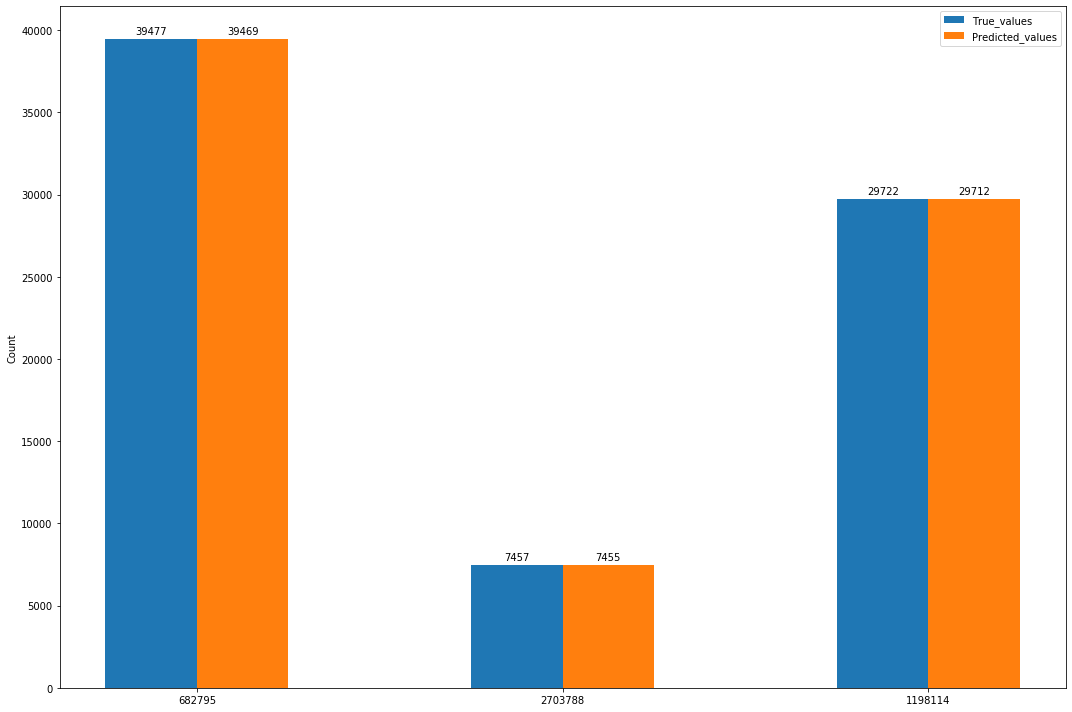

In [17]:
import matplotlib.pyplot as plt

true_values = []
predicted_values = []
labels = [int(get_taxid(x)) for x in random_genomes]


for i in range(number_of_genomes_to_test):
  true_values.append(random_count[i])
  predicted = 0
  for key, value in all_score.items():
    for taxid, count in value.items():
      if taxid == labels[i]:
        predicted += count
  predicted_values.append(predicted)


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,10))
rects1 = ax.bar(x - width/2, true_values, width, label='True_values')
rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted_values')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Minimizer Distribution

Because we XOR each minimizer with random number, we expected that distribution of minimizer will not be skewed to low-complexity Minimizers.

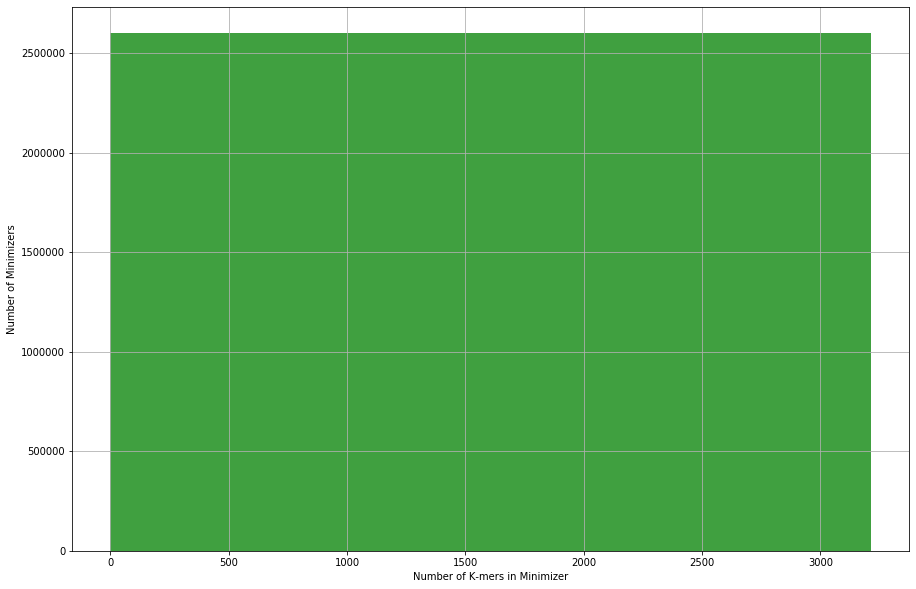

In [18]:
minimizer_count = []
for minimizer, k_mer in index_dic.items():
  minimizer_count.append(len(k_mer))

# the histogram of the data
plt.figure(figsize=(15,10))
n, bins, patches = plt.hist(minimizer_count, 1, facecolor='g', alpha=0.75)
plt.xlabel('Number of K-mers in Minimizer')
plt.ylabel('Number of Minimizers')
plt.grid(True)
plt.show()